In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## Loading Data

In [18]:
df = pd.read_csv("LYRICS_DATASET.csv")
df.head()

,Artist Name,Song Name,Lyrics
0,Phoebe Bridgers,Motion Sickness,I hate you for what you did And I miss you li...
1,Phoebe Bridgers,Killer,Sometimes I think I'm a killer I scared you i...
2,Phoebe Bridgers,Georgia,"Georgia, Georgia, I love your son And when he..."
3,Phoebe Bridgers,Kyoto,Day off in Kyoto Got bored at the temple Look...
4,Phoebe Bridgers,Would You Rather,"Playing ""would you rather"" When it comes to f..."


## Preprocessing

In [19]:
set_of_words =''
for i in df.Lyrics:
    if isinstance(i, float):
        i = str(i)
    set_of_words += i
    
set_of_words = set_of_words.lower()
print("Number of unique characters:", len(set(set_of_words)))

Number of unique characters: 72


In [20]:
to_remove = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', 
             '…', '\u205f', '\ufeff', '!', '&', '(', ')', '*', '-',  '/', ]
for symbol in to_remove:
    set_of_words = set_of_words.replace(symbol," ")


In [21]:
symb = sorted(list(set(set_of_words)))

L_set_of_words = len(set_of_words)
L_symb = len(symb)

mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_set_of_words)
print("Number of unique characters:", L_symb)

Total number of characters: 430652
Number of unique characters: 51


In [22]:
length = 40
features = []
targets = []
for i in range(0, L_set_of_words - length, 1):
    feature = set_of_words[i:i + length]
    target = set_of_words[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the set_of_words:", L_datapoints)

Total number of sequences in the set_of_words: 430612


In [23]:
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
y = np_utils.to_categorical(targets)

## Creating the model

In [24]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))       
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 256)           264192    
                                                                 
 dropout_2 (Dropout)         (None, 40, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
3365/3365 [==============================] - 52s 15ms/step - loss: 2.5590 - accuracy: 0.2697
Epoch 2/10
3365/3365 [==============================] - 48s 14ms/step - loss: 2.1831 - accuracy: 0.3657
Epoch 3/10
3365/3365 [==============================] - 49s 14ms/step - loss: 2.0114 - accuracy: 0.4145
Epoch 4/10
3365/3365 [==============================] - 48s 14ms/step - loss: 1.9087 - accuracy: 0.4431
Epoch 5/10
3365/3365 [==============================] - 49s 14ms/step - loss: 1.8362 - accuracy: 0.4634
Epoch 6/10
3365/3365 [==============================] - 48s 14ms/step - loss: 1.7801 - accuracy: 0.4782
Epoch 7/10
3365/3365 [==============================] - 48s 14ms/step - loss: 1.7327 - accuracy: 0.4916
Epoch 8/10
3365/3365 [==============================] - 48s 14ms/step - loss: 1.6938 - accuracy: 0.5015
Epoch 9/10
3365/3365 [==============================] - 49s 14ms/step - loss: 1.6589 - accuracy: 0.5115
Epoch 10/10
3365/3365 [==============================] - 49s 15m

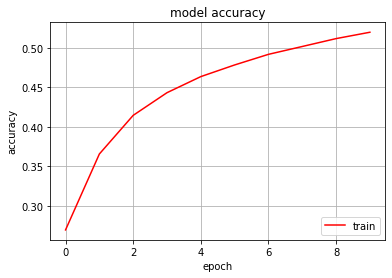

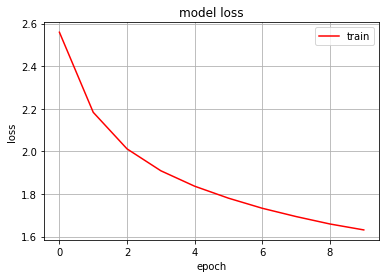

In [26]:
# Plot the Accuracy Curves
fig = plt.figure()
plt.plot(history.history['accuracy'],'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()

# Plot the Loss Curves
fig = plt.figure()
plt.plot(history.history['loss'],'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

In [27]:
def Lyrics_Generator(starting_words):
    output = ""
    Ch_count = 100
    starting_words = starting_words
    seed=[mapping[char] for char in starting_words]
    output += starting_words 
    for i in range(Ch_count):

        seed=[mapping[char] for char in starting_words]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        output += next_char
        starting_words = starting_words[1:] + next_char
       
    return output

In [28]:
poem1 = Lyrics_Generator('let dance for the rest of the night here')

In [29]:
poem1

"let dance for the rest of the night here in the way to be alone the same sun   i m gonna get you in my head i'm gonna get you in my head i'm"

In [40]:
def LSTM_Model(loss_, opt):
  model = Sequential()
  model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(256))
  model.add(Dropout(0.2))
  model.add(Dense(y.shape[1], activation='softmax'))       
  model.compile(loss=loss_, optimizer=opt, metrics=['accuracy'])    
  model.summary()
  history = model.fit(X, y, batch_size=128, epochs=10)

  # Plot the Accuracy Curves
  fig = plt.figure()
  plt.plot(history.history['accuracy'],'r')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.grid()

  # Plot the Loss Curves
  fig = plt.figure()
  plt.plot(history.history['loss'],'r')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.grid()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_14 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_15 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [==========================

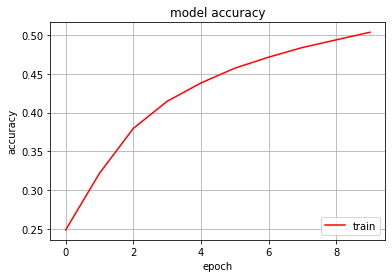

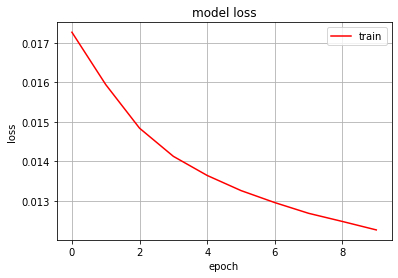

In [41]:
LSTM_Model('mse', 'adam')

In [42]:
poem2 = Lyrics_Generator('let dance for the rest of the night here')

In [43]:
poem2

"let dance for the rest of the night here in the way to be alone the same sun   i m gonna get you in my head i'm gonna get you in my head i'm"

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_16 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_17 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [==========================

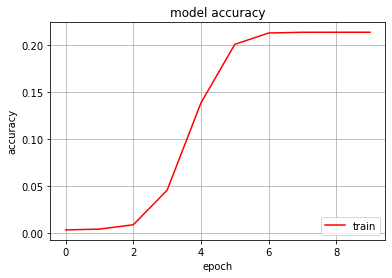

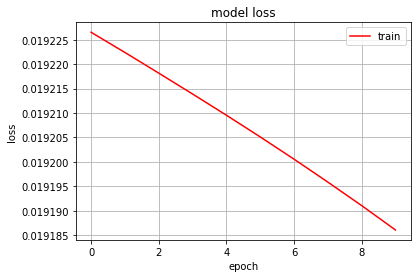

In [44]:
LSTM_Model('mse', 'sgd')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_18 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_19 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [==========================

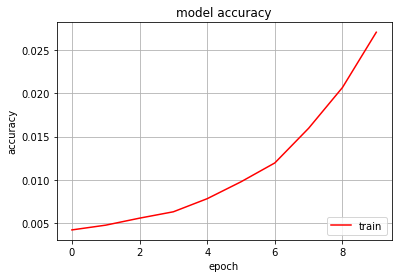

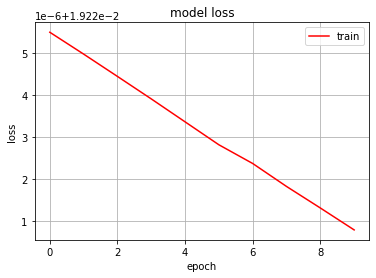

In [45]:
LSTM_Model('mse', 'adadelta')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_20 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_21 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [=========================

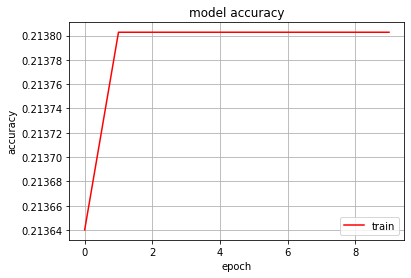

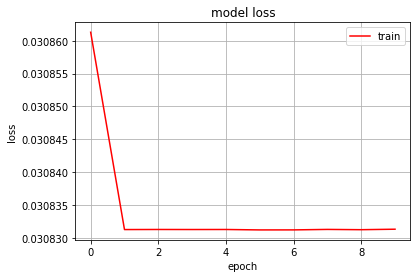

In [46]:
LSTM_Model('mae', 'adam')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_22 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_23 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [=========================

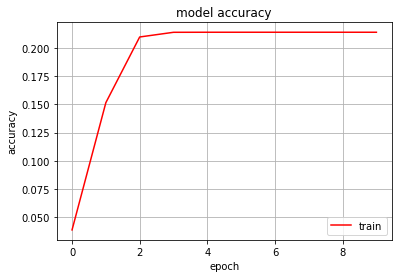

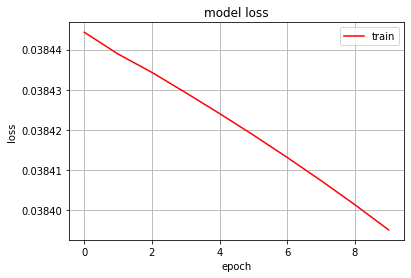

In [47]:
LSTM_Model('mae', 'sgd')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_24 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_25 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [=========================

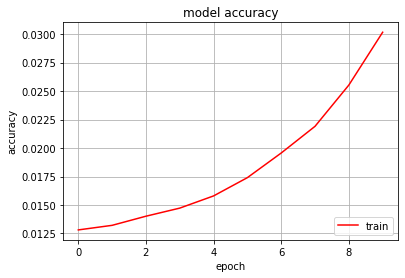

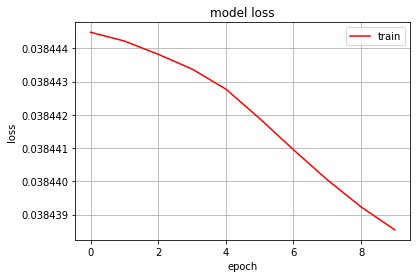

In [48]:
LSTM_Model('mae', 'adadelta')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_26 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_27 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [=========================

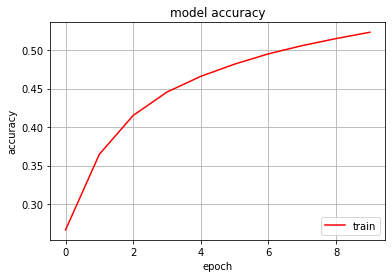

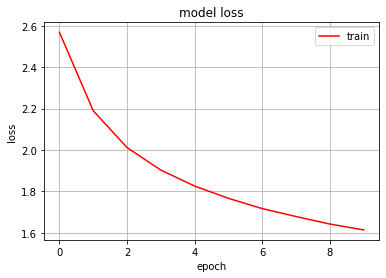

In [49]:
LSTM_Model('categorical_crossentropy', 'adam')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_28 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_29 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [=========================

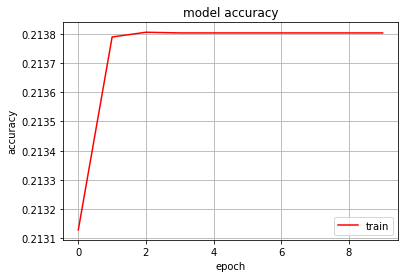

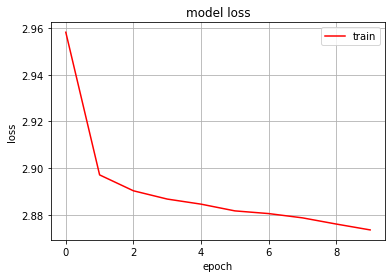

In [50]:
LSTM_Model('categorical_crossentropy', 'sgd')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 40, 256)           264192    
                                                                 
 dropout_30 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_31 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 51)                13107     
                                                                 
Total params: 802,611
Trainable params: 802,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3365/3365 [=========================

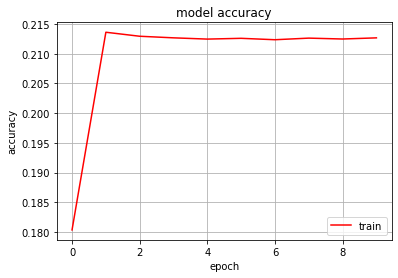

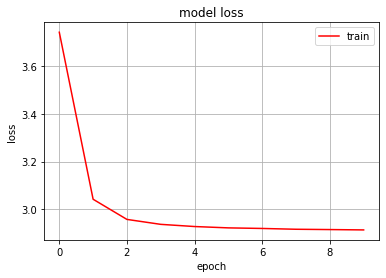

In [51]:
LSTM_Model('categorical_crossentropy', 'adadelta')